# Monte Carlo Simulation for FE
## IEOR 4703

### American option pricing via simulation: extracting the exercise boundary

In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
# import our polynomial function
from polynomials import constructX
# linear regression
from sklearn.linear_model import LinearRegression

### Parameters

In [2]:
r = 0.10
q = 0.01
s0 = 100
K = 100
sig = 0.40
T = 1

m = 365 # daily excercise
numPaths = 50000

dt = T/m
indicators = np.zeros(numPaths)

### Algorithm

In [3]:
np.random.seed(4456129)

sMin = 10
sMax = 610

# number of basis
d = 5

typeOfPolynomial = 'Chebychev_firstKind'

st = time()

# Initiate paths (not efficient; we should utilize the Brownian Bridge)
# simulate stock prices
s = np.zeros((m+1, numPaths))
t = np.linspace(0, T, m+1)
z = np.random.randn(m, numPaths)
delta_log_s = (r - q - sig*sig/2)*dt + sig*np.sqrt(dt)*z
log_s = np.zeros((m+1, numPaths))
log_s[0,:] = np.log(s0)
log_s[1:,:] = delta_log_s
log_s = np.cumsum(log_s, 0)
s = np.exp(log_s)

P = np.maximum(K - s[m,:], 0)
#print(np.exp(-r*T)*np.mean(P))
vHat = np.zeros(numPaths)
sArray = np.zeros(m+1)
sArray[m] = K

for i in np.arange(m-1, 0, -1):
    s_i = s[i, :]
    g = np.maximum(K - s_i, 0)
    # in-the-money indicator
    indicator = (g > 0)
    xi = s_i[indicator]
    if typeOfPolynomial == 'Laguerre':
        xXi = constructX(xi, typeOfPolynomial, d)
    elif typeOfPolynomial == 'Chebychev_firstKind' or typeOfPolynomial == 'Chebychev_secondKind':
        # make it shifted from (-1,1) to (sMin, sMax)
        xXi = constructX(2*(xi - sMin)/(sMax - sMin) - 1, typeOfPolynomial, d)
    yi = np.exp(-r*dt)*P[indicator]

    # regression
    reg = LinearRegression(fit_intercept=False).fit(xXi, yi)
    alpha = reg.coef_
    vH = np.dot(xXi, alpha)
    vHat[indicator] = vH

    len1 = len(xi)
    tmp = np.zeros((len1, 3))
    tmp[:, 0] = xi
    tmp[:, 1] = np.maximum(K - xi, 0)
    tmp[:, 2] = vH
    # sort tmp by xi
    tmp = tmp[tmp[:,0].argsort()]
    for j in np.arange(len1-1, -1, -1):
        if tmp[j,2] <= tmp[j,1]:
            sArray[i] = tmp[j,0]
            #print('%i, %f' % (i+1, sArray[i]))
            break

    indx = np.logical_and(indicator, g > vHat)
    P[indx] = g[indx]
    P[~indx] = np.exp(-r*dt)*P[~indx]

et = time()

print('Number of sims: %i' % numPaths)
print('Elapsed times was %f seconds' % (et-st))
premiumHat = np.exp(-r*dt) * np.mean(P)
print('American price: %f' % premiumHat)

Number of sims: 50000
Elapsed times was 8.530442 seconds
American price: 12.193514


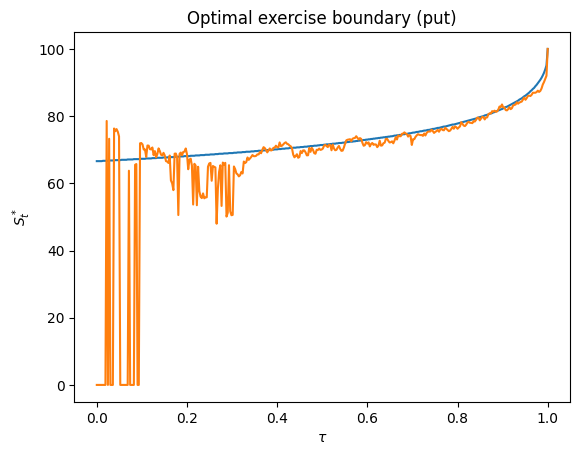

In [5]:
# load the exercise boundary
exerciseBoundary = np.loadtxt('exerciseBoundaryPut.dat')
plt.figure()
plt.plot(t, exerciseBoundary)
plt.plot(t, sArray)
plt.title('Optimal exercise boundary (put)')
plt.xlabel(r'$\tau$')
plt.ylabel('$S^*_t$')
plt.show()